In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import scipy
from scipy.io import loadmat
import pandas as pd

data = scipy.io.loadmat('/content/drive/MyDrive/minor_proj/Indian_pines_corrected.mat')
gt = scipy.io.loadmat('/content/drive/MyDrive/minor_proj/Indian_pines_gt.mat')


print(data.keys())
data1 = data["indian_pines_corrected"]
print(type(data1))

print(gt.keys())
gt1 = gt["indian_pines_gt"]
print(type(gt1))

dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
<class 'numpy.ndarray'>
dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])
<class 'numpy.ndarray'>


In [ ]:
H = data1.shape[0]
W = data1.shape[1]

In [ ]:
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model,Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D,Conv1D,multiply
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import *
from keras.layers.convolutional import UpSampling2D, Conv2D, UpSampling1D
from keras.initializers import RandomNormal
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from skimage.color import label2rgb
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [ ]:
import keras
tf.__version__

'2.12.0'

In [ ]:
! python --version

Python 3.9.16


In [ ]:
def define_discriminator(in_shape=(32,32,5,1), n_classes=17):
  model = Sequential()

  model.add(Conv3D(32, kernel_size=(4,4,7), strides=2, input_shape=in_shape, padding="same"))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv3D(64, kernel_size=(4,4,5),strides=2, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dropout(0.3))

  model.add(Conv3D(128, kernel_size=(4,4,3), strides=2, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dropout(0.3))

  model.add(Conv3D(256, kernel_size=(4,4,3), strides=2, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dropout(0.3))

  model.add(Conv2D(32, kernel_size=(4,4), strides=1,activation = 'relu', padding="same"))

  model.add(Flatten())

  img = Input(shape=in_shape)
  features = model(img)

  validity = Dense(1, activation="sigmoid")(features)
  label = Dense(n_classes, activation="softmax")(features)
  model = Model(img, [validity, label])
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer='Adam',metrics=['accuracy'])

  model.summary()

  return model

In [ ]:
#latent_dim = 100
def define_generator(latent_dim, n_classes=17):

  model = Sequential()

  model.add(Dense(2*2*128, activation="relu", input_dim=latent_dim))
  model.add(Reshape((2,2,128)))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=2,activation = 'relu', padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dropout(0.3))

  model.add(Conv2DTranspose(64, kernel_size=(4,4), strides=2,activation = "relu", padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dropout(0.3))

  model.add(Conv2DTranspose(32, kernel_size=(4,4), strides=2,activation = "relu", padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dropout(0.3))

  model.add(Conv2DTranspose(5, kernel_size=(4,4), strides=2,activation = "tanh", padding="same"))


  model.summary()

  noise = Input(shape=(latent_dim,))
  label = Input(shape=(1,), dtype='int32')
  label_embedding = Flatten()(Embedding(n_classes, latent_dim)(label))

  model_input = multiply([noise, label_embedding])
  img = model(model_input)
  model.summary()
  return Model([noise, label], img)



In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    # if removeZeroLabels:
    #     patchesData = patchesData[patchesLabels>0,:,:,:]
    #     patchesLabels = patchesLabels[patchesLabels>0]
    #     patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
# from sklearn.decomposition import PCA
# princi, pca = applyPCA(data1, numComponents = 5)
# princi.shape

In [ ]:
voxel = data1.reshape(-1,data1.shape[2])
scaler = StandardScaler()
voxel = scaler.fit_transform(voxel)
voxel = scaler.fit_transform(voxel)
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(voxel)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc'+str(x) for x in range(5)])
fullDataX = principalComponents.reshape(H,W,5)
fullDataY = gt1

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
from sklearn.model_selection import train_test_split

from patchify import patchify, unpatchify
paddedDatax = cv2.copyMakeBorder( fullDataX, 16,15,16,15, cv2.BORDER_REPLICATE)


X_train = patchify(paddedDatax, (32, 32, 5), step=1).reshape(-1,32,32,5)
print(X_train.shape)
y_train = fullDataY.reshape(-1,)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.50)
print(X_train.shape)

(21025, 32, 32, 5)
(10512, 32, 32, 5)


In [ ]:
# princi = princi.reshape(-1, princi.shape[2])

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# voxel = scaler.fit_transform(princi)
# voxel.shape

(21025, 5)

In [ ]:
# dat = princi.reshape(H,W,5)
# dat.shape

(145, 145, 5)

In [ ]:
# X1, y1 = createImageCubes(dat, gt1, windowSize=32)
# y1 = y1.reshape(-1,)
# print(X1.shape)
# print(y1.shape)

(21025, 32, 32, 5)
(21025,)


In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.5)

In [ ]:
def generate_real_test_samples(n_samples):
	images, labels =  X_test, y_test
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y

def generate_real_samples(n_samples):
	images, labels =  X_train, y_train
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=17):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y

def freeze(model):
    """Freeze model weights in every layer."""
    for layer in model.layers:
        layer.trainable = True

        if isinstance(layer, models.Model):
            freeze(layer)

def summarize_performance(step, g_model, latent_dim):
	filename = 'model_%04d.h5' % (step+1)
	freeze(g_model)
	g_model.save_weights(filename)
	for layer in g_model.layers:
		layer.trainable = False
	!cp -f *.h5 /content/drive/MyDrive/models2

In [ ]:
from keras import models

def train(g_model, d_model, gan_model, latent_dim, n_epochs=50, n_batch=4096):
	import warnings
	warnings.filterwarnings("ignore")
	bat_per_epo = int(10000 / n_batch)
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	prev_acc1 = 0.20
	i = 0
	while True:
		[X_real, labels_real], y_real = generate_real_samples(half_batch)

		d_loss_real = d_model.train_on_batch(X_real, [y_real, labels_real])
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss_fake = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
		[z_input, z_labels] = generate_latent_points(latent_dim, half_batch)
		y_gan = ones((half_batch, 1))
		g_loss = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		op_acc = d_loss[4]
		trainHist.append([d_loss,g_loss])
		print ("Training Metrics: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))

		[X_treal, labels_treal], y_treal = generate_real_test_samples(half_batch)
		d_loss_real = d_model.test_on_batch(X_treal, [y_treal, labels_treal])

		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss_fake = d_model.test_on_batch(X_fake, [y_fake, labels_fake])
		d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		y_gan = ones((n_batch, 1))
		g_loss = gan_model.test_on_batch([z_input, z_labels], [y_gan, z_labels])
		validationHist.append([d_loss,g_loss])
		print ("Validation Metrics: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))

		if (op_acc > 0.95 and d_loss[4] > 0.95) or i > n_epochs*10:
			prev_acc1 = op_acc
			prev_acc2 = d_loss[4]
			summarize_performance(i, d_model, latent_dim)
			break
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, d_model, latent_dim)
		i += 1

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)

discriminator.trainable = False
gan_output = discriminator(generator.output)
gan_model = Model(generator.input, gan_output)
opt = Adam(lr=0.002, beta_1=0.9)
gan_model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer='Adam')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 5,   0           []                               
                                1)]                                                               
                                                                                                  
 sequential_3 (Sequential)      (None, 128)          2266880     ['input_5[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 1)            129         ['sequential_3[0][0]']           
                                                                                                  
 dense_6 (Dense)                (None, 17)           2193        ['sequential_3[0][0]']     

In [ ]:
trainHist = []
validationHist = []
train(generator, discriminator, gan_model, latent_dim)

64/64 [==============================] - 0s 2ms/step
Training Metrics: 0 [D loss: 3.929237, acc.: 17.65%, op_acc: 6.20%] [G loss: 3.534888]
64/64 [==============================] - 0s 2ms/step
Validation Metrics: 0 [D loss: 3.404850, acc.: 91.28%, op_acc: 24.12%] [G loss: 3.532486]
64/64 [==============================] - 0s 2ms/step
Training Metrics: 1 [D loss: 2.917733, acc.: 81.35%, op_acc: 24.00%] [G loss: 3.506200]
64/64 [==============================] - 0s 2ms/step
Validation Metrics: 1 [D loss: 3.245767, acc.: 34.45%, op_acc: 18.36%] [G loss: 3.521849]
64/64 [==============================] - 0s 2ms/step
Training Metrics: 2 [D loss: 2.854445, acc.: 84.67%, op_acc: 23.17%] [G loss: 3.447788]
64/64 [==============================] - 0s 2ms/step
Validation Metrics: 2 [D loss: 2.834095, acc.: 50.00%, op_acc: 23.17%] [G loss: 3.488230]
64/64 [==============================] - 0s 2ms/step
Training Metrics: 3 [D loss: 2.311271, acc.: 99.90%, op_acc: 29.17%] [G loss: 3.354839]
64/64 [=

<Axes: >

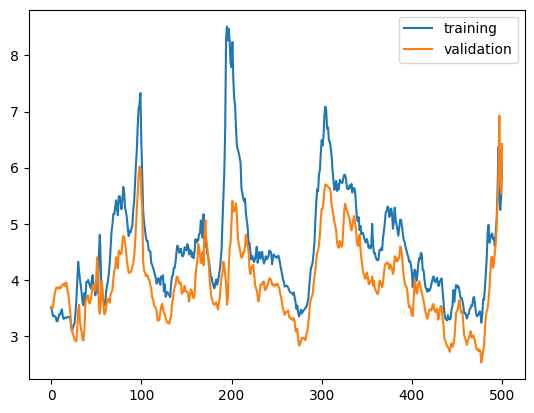

In [ ]:
x = [ trainHist[x][1][0] for x in range(len(trainHist))  ]
y = [ validationHist[x][1][0] for x in range(len(validationHist))  ]
dat = pd.DataFrame(data=x[1:len(validationHist)],columns=['training'])
dat['validation'] = y[1:len(validationHist)]
dat.plot()

<Axes: >

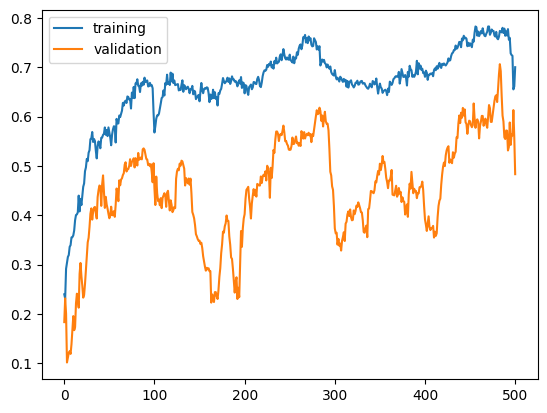

In [ ]:
x = [ trainHist[x][0][4] for x in range(len(trainHist))  ]
y = [ validationHist[x][0][4] for x in range(len(validationHist))  ]
dat = pd.DataFrame(data=x[1:len(validationHist)],columns=['training'])
dat['validation'] = y[1:len(validationHist)]
dat.plot()

<Axes: >

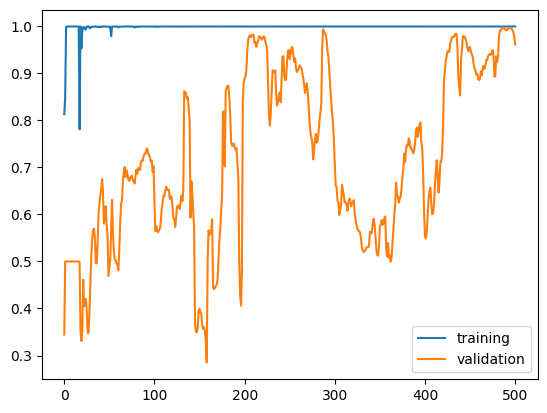

In [ ]:
x = [ trainHist[x][0][3] for x in range(len(trainHist))  ]
y = [ validationHist[x][0][3] for x in range(len(validationHist))  ]
dat = pd.DataFrame(data=x[1:len(validationHist)],columns=['training'])
dat['validation'] = y[1:len(validationHist)]
dat.plot()

In [ ]:
from keras.models import load_model
GANx = define_discriminator()
GANx.load_weights('/content/drive/MyDrive/models2/model_0280.h5')

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 32, 32, 5,   0           []                               
                                1)]                                                               
                                                                                                  
 sequential_14 (Sequential)     (None, 128)          2266880     ['input_17[0][0]']               
                                                                                                  
 dense_26 (Dense)               (None, 1)            129         ['sequential_14[0][0]']          
                                                                                                  
 dense_27 (Dense)               (None, 17)           2193        ['sequential_14[0][0]']   

658/658 [==============================] - 2s 3ms/step
Accuracy:  0.9307491082045184
Kappa 0.9027251328855288


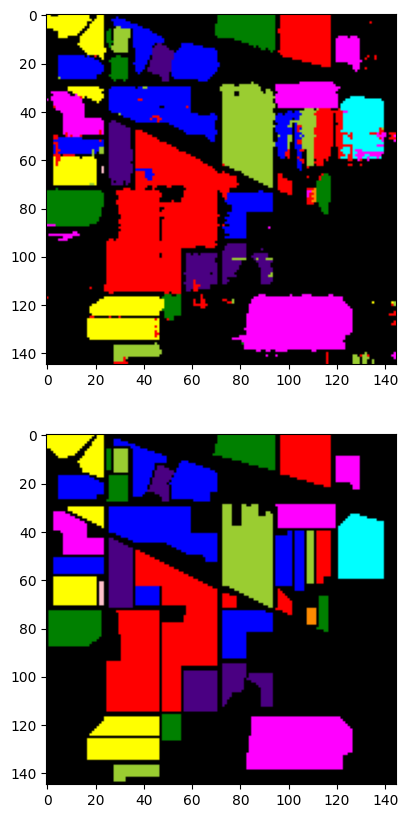

In [ ]:
from sklearn.metrics import cohen_kappa_score, accuracy_score
label_image = GANx.predict( patchify(paddedDatax, (32, 32, 5), step=1).reshape(-1,32, 32, 5) )
label_image = np.array(label_image[1])
y = []
for t in label_image:
  y.append(np.argmax(t))
label_image = np.array(y).reshape(145,145)
image_label_overlay = label2rgb(label_image)
fig, (ax1, ax2)  = plt.subplots(2,figsize=(10, 10))
print("Accuracy: ",accuracy_score(fullDataY.reshape(-1,), np.array(y)) )
print("Kappa", cohen_kappa_score(np.array(y), fullDataY.reshape(-1)) )
ax1.imshow(image_label_overlay)
image_label_overlay = label2rgb(fullDataY)
ax2.imshow(image_label_overlay)
